In [49]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200
        
name = 'mvi'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [179]:
import re
import torch
import numpy as np
import pickle 
import json
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

from nnsysident.training.trainers import standard_trainer
from nnsysident.models.models import stacked2d_poisson, stacked2d_zig, stacked2d_zil, stacked2d_gamma
from nnsysident.models.ensemble_models import Ensemble
from nnsysident.utility.data_helpers import extract_data_key
from nnsysident.datasets.mouse_loaders import static_loaders

from neuralpredictors.measures.zero_inflated_losses import ZIGLoss, ZILLoss
from neuralpredictors.measures import corr

from dataport.bcm.static import PreprocessedMouseData

random_seed = 27121992
device = 'cuda'

---

In [3]:
# Load model architecture configurations
with open('group233_model_configs.pkl', 'rb') as handle:
    zhiwei_configs = pickle.load(handle)
    
modulator_kwargs = zhiwei_configs["mod_key"]
shifter_kwargs = zhiwei_configs["shift_key"]
modulator_kwargs["bias"] = False
shifter_kwargs["bias"] = False

In [4]:
datasets =  [{'animal_id': 26614,
              'session': 1,
              'scan_idx': 16,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26614,
              'session': 2,
              'scan_idx': 17,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26726,
              'session': 6,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26726,
              'session': 7,
              'scan_idx': 13,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26942,
              'session': 1,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26942,
              'session': 2,
              'scan_idx': 8,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 27468,
              'session': 3,
              'scan_idx': 12,
              'scan_purpose': 'imagenet'},
             {'animal_id': 27468,
              'session': 4,
              'scan_idx': 7,
              'scan_purpose': 'dei_control_pair'}]

## Imagenet Data

In [5]:
imagenet_key = datasets[0]
assert imagenet_key["scan_purpose"] == "imagenet"
paths = ["./data/static{}-{}-{}-GrayImageNet-7bed7f7379d99271be5d144e5e59a8e7.zip".format(imagenet_key["animal_id"], imagenet_key["session"], imagenet_key["scan_idx"])]
img_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'loader_outputs': ["images", "responses", "pupil_center", "behavior"],
                  # 'loader_outputs': ["images", "responses"],
                  'normalize': True,
                  'exclude': ["images"],
                  'subtract_behavior_mean': True
                  }
    
img_dataloaders = static_loaders(**dataset_config)
img_dataset = img_dataloaders["test"][img_data_key].dataset

In [152]:
idx = np.array([(dat["animal_id"] == imagenet_key["animal_id"]) & (dat["session"] != imagenet_key["session"]) & (dat["scan_idx"] != imagenet_key["scan_idx"]) for dat in datasets])
dei_key = np.array(datasets)[idx].item()

assert dei_key["scan_purpose"] == "dei_control_pair"
paths = ["./data/static{}-{}-{}-GrayImageNetDEIInfo-7bed7f7379d99271be5d144e5e59a8e7.zip".format(dei_key["animal_id"], dei_key["session"], dei_key["scan_idx"])]
dei_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'loader_outputs': ["images", "responses", "pupil_center", "behavior"],
                  'normalize': True,
                  'exclude': ["images"],
                  'subtract_behavior_mean': True}

dei_dataloaders_training = static_loaders(**dataset_config)

dei_dataset_training = dei_dataloaders_training["test"][dei_data_key].dataset

---

## Models

### ZIG

In [6]:
# for random_seed in np.arange(5):
#     loc = np.exp(-10)

#     zig_model_config = {
#         "layers": 4,
#         "hidden_channels": 64,
#         "feature_reg_weight": 0.78,
#         "init_mu_range": 0.55,
#         "init_sigma": 0.4,
#         "readout_type": "MultipleGeneralizedFullGaussian2d",
#         'grid_mean_predictor': {'type': 'cortex',
#                                   'input_dimensions': 2,
#                                   'hidden_layers': 0,
#                                   'hidden_features': 0,
#                                   'final_tanh': False},
#         'zero_thresholds': {img_data_key: loc},

#         "input_kern": 15,
#         "gamma_input": 1,
#         "hidden_kern": 13,
#         "depth_separable": True,
#         "k_image_dependent": True,
#         "modulator_kwargs": modulator_kwargs,
#         "shifter_kwargs": shifter_kwargs,
#     }


#     zig_model = stacked2d_zig(img_dataloaders, random_seed, **zig_model_config)
#     zig_model.to(device);

#     score, output, state_dict = standard_trainer(zig_model,
#                                                img_dataloaders,
#                                                random_seed, 
#                                                loss_function="ZIGLoss", 
#                                                stop_function="get_loss", 
#                                                track_training=False, 
#                                                maximize=False)
#     zig_model.eval();
#     torch.save(state_dict, "ZIG_statedict" + img_data_key + f"-seed{random_seed}" + ".inshallah")

In [7]:
loc = np.exp(-10)

zig_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "feature_reg_weight": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    "readout_type": "MultipleGeneralizedFullGaussian2d",
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},
    'zero_thresholds': loc,

    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "k_image_dependent": True,
    "modulator_kwargs": modulator_kwargs,
    "shifter_kwargs": shifter_kwargs,
}


zig_model = stacked2d_zig(img_dataloaders, random_seed, **zig_model_config)
zig_model.to(device);

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_hash': 'a757e992ae449e3057ff1d512a51bd1e', 'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))


In [ ]:
score, output, state_dict = standard_trainer(zig_model,
                                           img_dataloaders,
                                           random_seed, 
                                           loss_function="ZIGLoss", 
                                           stop_function="get_loss", 
                                           track_training=True, 
                                           maximize=False,)
zig_model.eval();
# torch.save(state_dict, "ZIG_statedict" + img_data_key + ".inshallah")


# zig_model.load_state_dict(torch.load("ZIG_statedict" + img_data_key + ".inshallah"))
# zig_model.eval();

val_correlation: 0.29963976

zig_val_loss: -16377972.0

zig_train_loss: -150074690.0

### Gamma

In [180]:
gamma_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "feature_reg_weight": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    "readout_type": "MultipleGeneralizedFullGaussian2d",
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},

    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "k_image_dependent": True,
    "modulator_kwargs": modulator_kwargs,
    "shifter_kwargs": shifter_kwargs,
}

gamma_model = stacked2d_gamma(img_dataloaders, random_seed, **gamma_model_config)
gamma_model.to(device);

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_hash': 'a757e992ae449e3057ff1d512a51bd1e', 'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))


In [181]:
score, output, state_dict = standard_trainer(gamma_model,
                                           img_dataloaders,
                                           random_seed, 
                                           loss_function=gamma_model.loss_fn, 
                                           stop_function="get_loss", 
                                           track_training=True, 
                                           maximize=False,)
gamma_model.eval();

val_correlation 0.00651037
val_loss 5143881.0
train_loss 46948420.0


Epoch 1: 100% 71/71 [00:03<00:00, 22.03it/s]


val_correlation 0.041318145
val_loss -26307886.0
train_loss -238071040.0


Epoch 2: 100% 71/71 [00:03<00:00, 22.22it/s]


val_correlation 0.0725419
val_loss -26359376.0
train_loss -238535440.0


Epoch 3: 100% 71/71 [00:03<00:00, 22.28it/s]


val_correlation 0.0862491
val_loss -26413472.0
train_loss -239007660.0


Epoch 4: 100% 71/71 [00:03<00:00, 22.38it/s]


val_correlation 0.09789759
val_loss -26400320.0
train_loss -238900700.0


Epoch 5: 100% 71/71 [00:03<00:00, 22.42it/s]


val_correlation 0.10723823
val_loss -26416802.0
train_loss -239007780.0


Epoch 6: 100% 71/71 [00:03<00:00, 22.60it/s]


val_correlation 0.11259437
val_loss -26431392.0
train_loss -239139730.0


Epoch 7: 100% 71/71 [00:03<00:00, 22.68it/s]


val_correlation 0.116255865
val_loss -26418364.0
train_loss -239063820.0


Epoch 8: 100% 71/71 [00:03<00:00, 22.11it/s]


val_correlation 0.121935
val_loss -26441504.0
train_loss -239274270.0


Epoch 9: 100% 71/71 [00:03<00:00, 21.83it/s]


val_correlation 0.12843628
val_loss -26413700.0
train_loss -238996140.0


Epoch 10: 100% 71/71 [00:03<00:00, 22.84it/s]


val_correlation 0.13331111
val_loss -26439182.0
train_loss -239252700.0


Epoch 11: 100% 71/71 [00:03<00:00, 22.48it/s]


val_correlation 0.13776457
val_loss -26452176.0
train_loss -239359840.0


Epoch 12: 100% 71/71 [00:03<00:00, 22.79it/s]


val_correlation 0.14407255
val_loss -26447792.0
train_loss -239356860.0


Epoch 13: 100% 71/71 [00:03<00:00, 22.91it/s]


val_correlation 0.14933988
val_loss -26461496.0
train_loss -239467900.0


Epoch 14: 100% 71/71 [00:03<00:00, 22.86it/s]


val_correlation 0.15162636
val_loss -26441168.0
train_loss -239266190.0


Epoch 15: 100% 71/71 [00:03<00:00, 22.79it/s]


val_correlation 0.15616508
val_loss -26427882.0
train_loss -239243490.0


Epoch 16: 100% 71/71 [00:03<00:00, 22.46it/s]


val_correlation 0.16588467
val_loss -26461960.0
train_loss -239505060.0


Epoch 17: 100% 71/71 [00:03<00:00, 22.48it/s]


val_correlation 0.16470997
val_loss -26447124.0
train_loss -239377780.0


Epoch 18: 100% 71/71 [00:03<00:00, 22.72it/s]


val_correlation 0.17724153
val_loss -26469032.0
train_loss -239609890.0


Epoch 19: 100% 71/71 [00:03<00:00, 22.83it/s]


val_correlation 0.18850818
val_loss -26489724.0
train_loss -239768880.0


Epoch 20: 100% 71/71 [00:03<00:00, 22.18it/s]


val_correlation 0.19748126
val_loss -26485042.0
train_loss -239753650.0


Epoch 21: 100% 71/71 [00:03<00:00, 22.76it/s]


val_correlation 0.20162155
val_loss -26503404.0
train_loss -239944590.0


Epoch 22: 100% 71/71 [00:03<00:00, 22.74it/s]


val_correlation 0.20305926
val_loss -26500032.0
train_loss -239921920.0


Epoch 23: 100% 71/71 [00:03<00:00, 22.63it/s]


val_correlation 0.21010874
val_loss -26475056.0
train_loss -239800540.0


Epoch 24: 100% 71/71 [00:03<00:00, 22.40it/s]


val_correlation 0.2179845
val_loss -26515302.0
train_loss -240077650.0


Epoch 25: 100% 71/71 [00:03<00:00, 22.72it/s]


val_correlation 0.224077
val_loss -26489050.0
train_loss -239976050.0


Epoch 26: 100% 71/71 [00:03<00:00, 22.79it/s]


val_correlation 0.22619595
val_loss -26508300.0
train_loss -240093180.0


Epoch 27: 100% 71/71 [00:03<00:00, 22.82it/s]


val_correlation 0.22894411
val_loss -26509744.0
train_loss -240114130.0


Epoch 28: 100% 71/71 [00:03<00:00, 22.82it/s]


val_correlation 0.22949907
val_loss -26511372.0
train_loss -240040210.0


Epoch 29: 100% 71/71 [00:03<00:00, 22.65it/s]


val_correlation 0.23660181
val_loss -26526108.0
train_loss -240256340.0


Epoch 30: 100% 71/71 [00:03<00:00, 22.51it/s]


val_correlation 0.24072663
val_loss -26523608.0
train_loss -240257740.0


Epoch 31: 100% 71/71 [00:03<00:00, 22.64it/s]


val_correlation 0.23969157
val_loss -26520028.0
train_loss -240195040.0


Epoch 32: 100% 71/71 [00:03<00:00, 22.34it/s]


val_correlation 0.24223599
val_loss -26521050.0
train_loss -240254610.0


Epoch 33: 100% 71/71 [00:03<00:00, 22.70it/s]


val_correlation 0.2455426
val_loss -26512852.0
train_loss -240242300.0


Epoch 34: 100% 71/71 [00:03<00:00, 22.19it/s]


val_correlation 0.23660181
val_loss -26526108.0
train_loss -240256320.0


Epoch 35: 100% 71/71 [00:03<00:00, 22.43it/s]


Epoch 00035: reducing learning rate of group 0 to 1.5000e-03.
val_correlation 0.23336355
val_loss -26500824.0
train_loss -240043310.0


Epoch 36: 100% 71/71 [00:03<00:00, 22.29it/s]


val_correlation 0.23633844
val_loss -26516756.0
train_loss -240280940.0


Epoch 37: 100% 71/71 [00:03<00:00, 22.96it/s]


val_correlation 0.2473261
val_loss -26552008.0
train_loss -240506510.0


Epoch 38: 100% 71/71 [00:03<00:00, 23.08it/s]


val_correlation 0.24793133
val_loss -26545404.0
train_loss -240485680.0


Epoch 39: 100% 71/71 [00:03<00:00, 23.01it/s]


val_correlation 0.2526486
val_loss -26550430.0
train_loss -240565780.0


Epoch 40: 100% 71/71 [00:03<00:00, 22.44it/s]


val_correlation 0.2509822
val_loss -26549894.0
train_loss -240518460.0


Epoch 41: 100% 71/71 [00:03<00:00, 22.69it/s]


val_correlation 0.25394028
val_loss -26555176.0
train_loss -240581840.0


Epoch 42: 100% 71/71 [00:03<00:00, 22.48it/s]


val_correlation 0.24696232
val_loss -26533156.0
train_loss -240423460.0


Epoch 43: 100% 71/71 [00:03<00:00, 22.62it/s]


val_correlation 0.2550574
val_loss -26549940.0
train_loss -240575920.0


Epoch 44: 100% 71/71 [00:03<00:00, 22.38it/s]


val_correlation 0.2515652
val_loss -26542080.0
train_loss -240517970.0


Epoch 45: 100% 71/71 [00:03<00:00, 22.32it/s]


val_correlation 0.2564169
val_loss -26552936.0
train_loss -240610190.0


Epoch 46: 100% 71/71 [00:03<00:00, 22.16it/s]


val_correlation 0.25394028
val_loss -26555176.0
train_loss -240581860.0


Epoch 47: 100% 71/71 [00:03<00:00, 23.11it/s]


Epoch 00047: reducing learning rate of group 0 to 4.5000e-04.
val_correlation 0.2532183
val_loss -26549836.0
train_loss -240564750.0


Epoch 48: 100% 71/71 [00:03<00:00, 22.41it/s]


val_correlation 0.25153437
val_loss -26547864.0
train_loss -240588640.0


Epoch 49: 100% 71/71 [00:03<00:00, 22.56it/s]


val_correlation 0.2570801
val_loss -26555132.0
train_loss -240625570.0


Epoch 50: 100% 71/71 [00:03<00:00, 22.76it/s]


val_correlation 0.25664115
val_loss -26557752.0
train_loss -240665340.0


Epoch 51: 100% 71/71 [00:03<00:00, 22.70it/s]


val_correlation 0.25684002
val_loss -26561436.0
train_loss -240680740.0


Epoch 52: 100% 71/71 [00:03<00:00, 22.86it/s]


val_correlation 0.2555762
val_loss -26551828.0
train_loss -240673740.0


Epoch 53: 100% 71/71 [00:03<00:00, 22.98it/s]


val_correlation 0.25735322
val_loss -26551942.0
train_loss -240636400.0


Epoch 54: 100% 71/71 [00:03<00:00, 22.43it/s]


val_correlation 0.25610974
val_loss -26554840.0
train_loss -240646700.0


Epoch 55: 100% 71/71 [00:03<00:00, 22.42it/s]


val_correlation 0.25996712
val_loss -26562960.0
train_loss -240706400.0


Epoch 56: 100% 71/71 [00:03<00:00, 23.11it/s]


val_correlation 0.25702888
val_loss -26558164.0
train_loss -240671090.0


Epoch 57: 100% 71/71 [00:03<00:00, 23.05it/s]


val_correlation 0.2608993
val_loss -26558288.0
train_loss -240733860.0


Epoch 58: 100% 71/71 [00:03<00:00, 23.09it/s]


val_correlation 0.2588223
val_loss -26558332.0
train_loss -240675310.0


Epoch 59: 100% 71/71 [00:03<00:00, 23.12it/s]


val_correlation 0.25684366
val_loss -26543920.0
train_loss -240656780.0


Epoch 60: 100% 71/71 [00:03<00:00, 21.93it/s]
/usr/local/lib/python3.9/dist-packages/neuralpredictors/measures/modules.py:168: UserWarning: Gammaloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Gammaloss is averaged per batch. It's recommended to use `sum` instead")


### Poisson

In [ ]:
# for random_seed in np.arange(5):

#     poisson_model_config = {
#         "layers": 4,
#         "hidden_channels": 64,
#         "gamma_readout": 0.78,
#         "init_mu_range": 0.55,
#         "init_sigma": 0.4,
#         "readout_type": "MultipleGeneralizedFullGaussian2d",
#         'grid_mean_predictor': {'type': 'cortex',
#                                   'input_dimensions': 2,
#                                   'hidden_layers': 0,
#                                   'hidden_features': 0,
#                                   'final_tanh': False},
#         "input_kern": 15,
#         "gamma_input": 1,
#         "hidden_kern": 13,
#         "depth_separable": True,
#         "modulator_kwargs": modulator_kwargs,
#         "shifter_kwargs": shifter_kwargs,  
#     }


#     poisson_model = stacked2d_poisson(img_dataloaders, random_seed, **poisson_model_config)
#     poisson_model.to(device);

#     score, output, state_dict = standard_trainer(poisson_model,
#                                                  img_dataloaders,
#                                                  random_seed,
#                                                  loss_function="PoissonLoss",
#                                                  track_training=False, )
#     poisson_model.eval();
#     torch.save(state_dict, "Poisson_statedict" + img_data_key + f"-seed{random_seed} + ".inshallah"")

In [9]:
poisson_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "gamma_readout": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    "readout_type": "MultipleGeneralizedFullGaussian2d",
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},
    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "modulator_kwargs": modulator_kwargs,
    "shifter_kwargs": shifter_kwargs,  
}

poisson_model = stacked2d_poisson(img_dataloaders, random_seed, **poisson_model_config)
poisson_model.to(device);

In [ ]:
score, output, state_dict = standard_trainer(poisson_model,
                                             img_dataloaders,
                                             random_seed,
                                             loss_function="PoissonLoss",
                                             track_training=True, )
poisson_model.eval();
# torch.save(state_dict, "Poisson_statedict" + img_data_key + ".inshallah")


# poisson_model.load_state_dict(torch.load("Poisson_statedict" + img_data_key + ".inshallah"))
# poisson_model.eval();

In [ ]:
score

val_correlation 0.32643822

val_loss 2107371.0

train_loss 17724226.0

---

# Compare DEIs/MEIs

### DEI data

In [51]:
imagenet_key = datasets[0]

In [99]:
idx = np.array([(dat["animal_id"] == imagenet_key["animal_id"]) & (dat["session"] != imagenet_key["session"]) & (dat["scan_idx"] != imagenet_key["scan_idx"]) for dat in datasets])
dei_key = np.array(datasets)[idx].item()

assert dei_key["scan_purpose"] == "dei_control_pair"
paths = ["./data/static{}-{}-{}-GrayImageNetDEIInfo-7bed7f7379d99271be5d144e5e59a8e7.zip".format(dei_key["animal_id"], dei_key["session"], dei_key["scan_idx"])]
dei_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'return_test_sampler': True,
                  'tier': "test",
                  'loader_outputs': ["images", 'responses', 'trial_idx', "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances",  "pupil_center", "behavior"],
                  'normalize': True,
                  'exclude': ["images", "trial_idx", "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances"],
                  'subtract_behavior_mean': True}

dei_dataloaders = static_loaders(**dataset_config)

dei_dataset = dei_dataloaders["test"][dei_data_key].dataset

Returning only test sampler with repeats...


In [61]:
images, responses, trial_idxs, dei_unit_ids, dei_src_unit_ids, dei_mean_distances = [], [], [], [], [], []
for image, response, trial_idx, dei_unit_id, dei_src_unit_id, dei_mean_distance, pupil_center, behavior in dei_dataloaders["test"][dei_data_key]:
    if (len(response) == 20) & (torch.unique(dei_mean_distance <= 10)):
        images.append(image)
        responses.append(response)
        trial_idxs.append(trial_idx)
        dei_unit_ids.append(dei_unit_id)
        dei_src_unit_ids.append(dei_src_unit_id)
        dei_mean_distances.append(dei_mean_distance)
images = torch.stack(images)
responses = torch.stack(responses)
trial_idxs = torch.stack(trial_idxs).cpu().data.numpy()
dei_unit_ids = torch.stack(dei_unit_ids).cpu().data.numpy()
dei_src_unit_ids = torch.stack(dei_src_unit_ids).cpu().data.numpy()
dei_mean_distances = torch.stack(dei_mean_distances).cpu().data.numpy()

### Diff of DEIs

In [21]:
my_unit_ids = []
imgs = np.full((3, len(possible_src_unit_ids), 1, 36, 64), np.nan)
for i, possible_src_unit_id in enumerate(possible_src_unit_ids):
    image_idx = np.unique(np.where(dei_src_unit_ids == possible_src_unit_id)[0])
    my_unit_ids.append(int(possible_src_unit_id))


    img = torch.unique(images[image_idx], dim=1).squeeze(1)
    mei_dei_idx = [0, 1, 2]
    if len(image_idx) != 3:
        idx = np.where(np.isin(dei_dataset.trial_info.trial_idx, trial_idxs[image_idx]))[0]
        if 'mask_fixed_mei' in np.unique(dei_dataset.trial_info.frame_image_class[idx]):
            mei_dei_idx = [0, 1] if len(image_idx) == 2 else [0]
        else:
            mei_dei_idx = [1, 2] if len(image_idx) == 2 else [1]
    imgs[mei_dei_idx, i, :, :, :] = img.cpu().data

In [22]:
my_unit_ids[:9]

[1056, 3853, 1673, 2102, 6831, 4794, 6816, 6362, 5132]

Text(0.5, 1.0, 'DIFF(DEIs)')

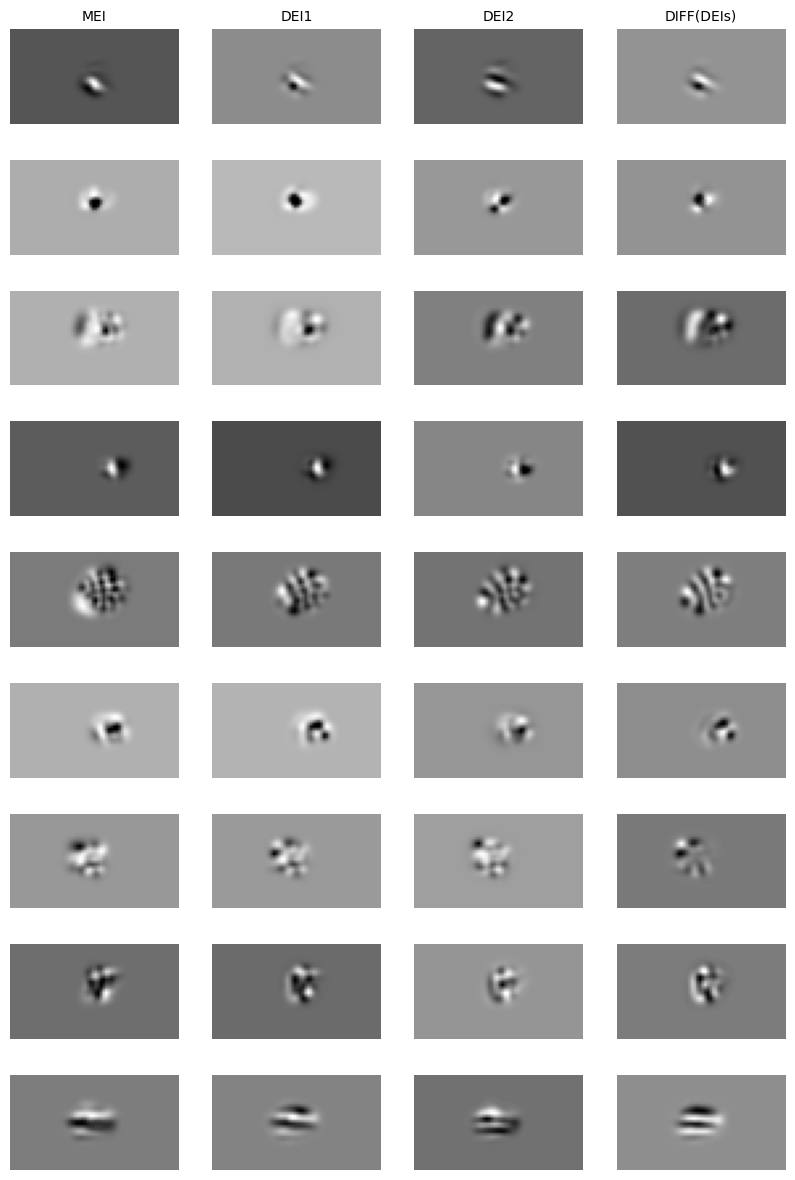

In [12]:
fig, axes = plt.subplots(9, 4, figsize=(10, 15), dpi=100)
fontsize = 10

for i in range(9):
    axes[i, 0].imshow(imgs[0, i, 0, :, :], cmap="gray")
    axes[i, 1].imshow(imgs[1, i, 0, :, :], cmap="gray")
    axes[i, 2].imshow(imgs[2, i, 0, :, :], cmap="gray")
    axes[i, 3].imshow(imgs[1, i, 0, :, :] - imgs[2, i, 0, :, :], cmap="gray")
for ax in axes.flatten():
    ax.axis("off")
axes[0, 0].set_title("MEI", fontsize=fontsize)
axes[0, 1].set_title("DEI1", fontsize=fontsize)
axes[0, 2].set_title("DEI2", fontsize=fontsize)
axes[0, 3].set_title("DIFF(DEIs)", fontsize=fontsize)
# fig.savefig("diff_of_deis" + ".png", bbox_inches="tight", transparent=False)

### Get data for following plots

In [55]:
# Get possible unit ids (in the source-dataset frame)
possible_src_unit_ids = np.unique(dei_src_unit_ids, axis=1).squeeze()

# Sort according to mean distances (increasing)
src_sort_idx = np.argsort(np.unique(dei_mean_distances, axis=1).squeeze())
possible_src_unit_ids = possible_src_unit_ids[src_sort_idx]

# Remove duplicates (from several DEIs/MEI)
_, idx = np.unique(possible_src_unit_ids, return_index=True)
possible_src_unit_ids = possible_src_unit_ids[np.sort(idx)]

In [ ]:
zig_model = Ensemble(zig_se2d_fullgaussian2d, zig_model_config, img_dataloaders, "ZIG_statedict" + img_data_key, np.arange(5), device=device)
poisson_model = Ensemble(poisson_se2d_fullgaussian2d, poisson_model_config, img_dataloaders, "Poisson_statedict" + img_data_key, np.arange(5), device=device)

# zig_model.shifter = None
# poisson_model.shifter = None
# poisson_model.modulator = None

In [57]:
zig_means = np.full((3, len(possible_src_unit_ids)), np.nan)
zig_variances = np.full((3, len(possible_src_unit_ids)), np.nan)
poisson_means = np.full((3, len(possible_src_unit_ids)), np.nan)
poisson_variances = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_means = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_vars = np.full((3, len(possible_src_unit_ids)), np.nan)
imgs = np.full((3, len(possible_src_unit_ids), 1, 36, 64), np.nan)
for i, possible_src_unit_id in enumerate(possible_src_unit_ids):
    image_idx = np.unique(np.where(dei_src_unit_ids == possible_src_unit_id)[0])

    dei_neuron_id = np.unique(dei_unit_ids[image_idx]).item()
    src_neuron_id = np.unique(dei_src_unit_ids[image_idx]).item()
    src_neuron_idx = np.where(img_dataset.neurons.unit_ids == src_neuron_id)[0].item()
    dei_neuron_idx = np.where(dei_dataset.neurons.unit_ids == dei_neuron_id)[0].item()

    img = torch.unique(images[image_idx], dim=1).squeeze(1)
    mei_dei_idx = [0, 1, 2]
    if len(image_idx) != 3:
        idx = np.where(np.isin(dei_dataset.trial_info.trial_idx, trial_idxs[image_idx]))[0]
        if 'mask_fixed_mei' in np.unique(dei_dataset.trial_info.frame_image_class[idx]):
            mei_dei_idx = [0, 1] if len(image_idx) == 2 else [0]
        else:
            mei_dei_idx = [1, 2] if len(image_idx) == 2 else [1]
    imgs[mei_dei_idx, i, :, :, :] = img.cpu().data
    
    # TODO: Keep this line?
#     img = torch.stack([((im - im.mean()) / (im.std())) for im in img.squeeze()])[:, None]

    behavior = torch.zeros((img.shape[0], 3)).to(device)
    pupil_center = torch.zeros((img.shape[0], 2)).to(device)
    
    zig_means_ = zig_model.predict_mean(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    zig_variances_ = zig_model.predict_variance(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    poisson_means_ = poisson_model.predict_mean(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    poisson_variances_ = poisson_model.predict_variance(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()

    zig_means[mei_dei_idx, i] = zig_means_[:, src_neuron_idx]
    zig_variances[mei_dei_idx, i] = zig_variances_[:, src_neuron_idx]
    poisson_means[mei_dei_idx, i] = poisson_means_[:, src_neuron_idx]
    poisson_variances[mei_dei_idx, i] = poisson_variances_[:, src_neuron_idx]
    
    real_resp_means[mei_dei_idx, i] = np.mean(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
    real_resp_vars[mei_dei_idx, i] = np.var(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
keep_idx = ~np.isnan(zig_means).any(axis=0)

### Compare Zhiwei Model with Konstantin model

In [ ]:
with open(r"group233_mei_dei_resps.pkl", "rb") as input_file:
    e = pickle.load(input_file).T

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10), dpi=150, sharex=True, sharey=True)
fontsize = 10


y_zhiwei = e / e[0, :]
y_zig = zig_means / zig_means[0, :]
y_zig = y_zig[:, keep_idx]
y_poisson = poisson_means / poisson_means[0, :]
y_poisson = y_poisson[:, keep_idx]
y_real = real_resp_means / real_resp_means[0, :]
y_real = y_real[:, keep_idx]
x = np.arange(y_real.shape[1])

# Zhiwei
for i in range(3):
    axes[0].plot(x, y_zhiwei[i,:], ls="", marker="x")

# ZIG
for i in range(3):
    axes[1].plot(x, y_zig[i,:], ls="", marker="x")
    
# Poisson
for i in range(3):
    axes[2].plot(x, y_poisson[i,:], ls="", marker="x")
    axes[2].ticklabel_format(useOffset=False)
    
# Real data
for i, label in enumerate(["MEI", "DEI1", "DEI2"]):
    axes[3].plot(x, y_real[i,:], ls="", marker="x", label=label)
    
    
axes[0].set_title("Zhiwei model", fontsize=fontsize*1.3)
axes[1].set_title("ZIG model", fontsize=fontsize*1.3)
axes[2].set_title("Poisson model", fontsize=fontsize*1.3)
axes[3].set_title("Real data  (averaged over 20 repeats)", fontsize=fontsize*1.3)
axes[3].set_xlabel("neurons", fontsize=fontsize*1.2)
axes[3].set_ylabel(r"$\frac{resp}{resp(MEI)}$", fontsize=fontsize*1.2)

axes[0].set(ylim=[0, 1.5])

# axes[3].legend(bbox_to_anchor=(0.15, 1., 0, 0), frameon=True, fontsize=fontsize*.8)
axes[3].legend(bbox_to_anchor=(0.1, 1.1, 0, 0), frameon=True, fontsize=fontsize*.8)

sns.despine(trim=True)
# fig.savefig("Zhiwei_Model_Comparison" + ".png", bbox_inches="tight", transparent=False)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_zhiwei[0], y_poisson[0])
ax.scatter(y_zhiwei[0], y_zig[0])
ax.scatter(y_zhiwei[0], y_real[0])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]])

#### Rank correlation

In [ ]:
zig_zhiwei, poisson_zhiwei, zig_real, poisson_real, zhiwei_real = [], [], [], [], []
for i in range(e.shape[-1]):
    zig_zhiwei_, p = spearmanr(e[:, i], zig_means[:, keep_idx][:, i], axis=0)
    poisson_zhiwei_, p = spearmanr(e[:, i], poisson_means[:, keep_idx][:, i], axis=0)
    zig_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], zig_means[:, keep_idx][:, i], axis=0)
    poisson_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], poisson_means[:, keep_idx][:, i], axis=0)
    zhiwei_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], e[:, i], axis=0)
    
    zig_zhiwei.append(zig_zhiwei_)
    poisson_zhiwei.append(poisson_zhiwei_)
    zig_real.append(zig_real_)
    poisson_real.append(poisson_real_)
    zhiwei_real.append(zhiwei_real_)

print("ZIG     |  Zhiwei: {:.5f}".format(np.mean(zig_zhiwei)))
print("Poisson |  Zhiwei: {:.5f}".format(np.mean(poisson_zhiwei)))
print("ZIG     |  Real:   {:.5f}".format(np.mean(zig_real)))
print("Poisson |  Real:   {:.5f}".format(np.mean(poisson_real)))
print("Zhiwei  |  Real:   {:.5f}".format(np.mean(zhiwei_real)))

#### Full Correlation

In [ ]:
zig_zhiwei = np.mean(corr(e, zig_means[:, keep_idx], axis=0))
poisson_zhiwei = np.mean(corr(e, poisson_means[:, keep_idx], axis=0))
zig_real = np.mean(corr(real_resp_means[:, keep_idx], zig_means[:, keep_idx], axis=0))
poisson_real = np.mean(corr(real_resp_means[:, keep_idx], poisson_means[:, keep_idx], axis=0))
zhiwei_real = np.mean(corr(real_resp_means[:, keep_idx], e, axis=0))

print("ZIG     |  Zhiwei: {:.5f}".format(np.mean(zig_zhiwei)))
print("Poisson |  Zhiwei: {:.5f}".format(np.mean(poisson_zhiwei)))
print("ZIG     |  Real:   {:.5f}".format(np.mean(zig_real)))
print("Poisson |  Real:   {:.5f}".format(np.mean(poisson_real)))
print("Zhiwei  |  Real:   {:.5f}".format(np.mean(zhiwei_real)))

___

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
color = "navy"
ec="white"
fontsize = 15

axes[0].scatter(real_resp_means.flatten(), real_resp_vars.flatten(), color=color, ec=ec)
axes[0].set_xlabel("Means", fontsize=fontsize)
axes[0].set_ylabel("Variances", fontsize=fontsize)
axes[0].set_title("Real Data", fontsize=fontsize*1.3)

axes[1].scatter(zig_means.flatten(), zig_variances.flatten(), color=color, ec=ec)
axes[1].set_title("ZIG", fontsize=fontsize*1.3)
axes[1].plot([axes[1].get_xlim()[0], axes[1].get_xlim()[1]], [axes[1].get_xlim()[0], axes[1].get_xlim()[1]], ls="--", color="grey", label="Poisson")
# axes[1].set(xlim=[0, 15], ylim=[0, 400])
axes[1].legend(frameon=False, bbox_to_anchor=[.4,.8,0,0])
sns.despine(trim=True)

# fig.savefig("mean_variance_comparison" + ".png", bbox_inches="tight", transparent=False)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
color = "navy"
ec="white"
fontsize = 15

axes[0].plot(real_resp_means, real_resp_vars, marker="", lw=1)
axes[0].set_xlabel("Means", fontsize=fontsize)
axes[0].set_ylabel("Variances", fontsize=fontsize)
axes[0].set_title("Real Data", fontsize=fontsize*1.3)

axes[1].plot(zig_means, zig_variances, marker="", lw=1)
axes[1].set_title("ZIG", fontsize=fontsize*1.3)
axes[1].plot([axes[1].get_xlim()[0], axes[1].get_xlim()[1]], [axes[1].get_xlim()[0], axes[1].get_xlim()[1]], ls="--", color="grey", label="Poisson")
# axes[1].set(xlim=[0, 15], ylim=[0, 400])
axes[1].legend(frameon=False, bbox_to_anchor=[.4,.8,0,0])
sns.despine(trim=True)

# fig.savefig("mean_variance_comparison_lines" + ".png", bbox_inches="tight", transparent=False)

___

## Correlation to mean and variance

In [172]:
features_trained = zig_model.readout["26614-1-16-0"].features.data.cpu().numpy()
features_init = zig_model_dei.readout["26614-2-17-0"].features.data.cpu().numpy()

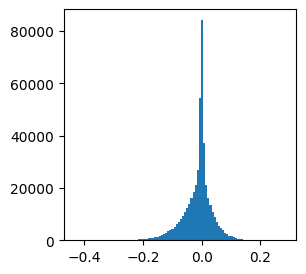

In [176]:
i = 2
plt.hist(features_trained[i].flatten(), bins=100);

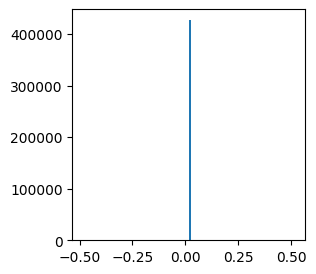

In [177]:
plt.hist(features_init[i].flatten(), bins=100);

In [158]:
zig_model_dei = stacked2d_zig(dei_dataloaders_training, random_seed, **zig_model_config)
zig_model_dei.load_state_dict(zig_model.state_dict(), strict=False)
zig_model_dei.to(device);

# score, output, state_dict = standard_trainer(zig_model_dei,
#                                            dei_dataloaders_training,
#                                            random_seed, 
#                                            loss_function="ZIGLoss", 
#                                            stop_function="get_loss", 
#                                            track_training=True, 
#                                            maximize=False,
#                                            detach_core=True)
# zig_model_dei.eval();
# torch.save(state_dict, "ZIG_statedict" + img_data_key + ".inshallah")


# zig_model_dei.load_state_dict(torch.load("ZIG_statedict" + img_data_key + ".inshallah"))
# zig_model_dei.eval();

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_hash': 'a757e992ae449e3057ff1d512a51bd1e', 'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))


In [ ]:
poisson_model_dei = stacked2d_poisson(dei_dataloaders_training, random_seed, **poisson_model_config)
poisson_model_dei.load_state_dict(poisson_model.state_dict(), strict=False)
poisson_model_dei.to(device);

score, output, state_dict = standard_trainer(poisson_model_dei,
                                             dei_dataloaders_training,
                                             random_seed,
                                             loss_function="PoissonLoss",
                                             track_training=True, 
                                             detach_core=True)
poisson_model_dei.eval();
# torch.save(state_dict, "Poisson_statedict" + img_data_key + ".inshallah")


# poisson_model_dei.load_state_dict(torch.load("Poisson_statedict" + img_data_key + ".inshallah"))
# poisson_model_dei.eval();

In [131]:
zig_means, zig_variances, poisson_means, poisson_variances, real_means, real_variances = [], [] , [], [], [], []
for image, response, trial_idx, dei_unit_id, dei_src_unit_id, dei_mean_distance, pupil_center, behavior in dei_dataloaders["test"][dei_data_key]:
    zig_means.append(zig_model_dei.predict_mean(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    zig_variances.append(zig_model_dei.predict_variance(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    
    poisson_means.append(poisson_model_dei.predict_mean(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    poisson_variances.append(poisson_model_dei.predict_variance(image, data_key=dei_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy().mean(0))
    
    real_means.append(torch.mean(response, axis=0).cpu().data.numpy())
    real_variances.append(torch.var(response, axis=0).cpu().data.numpy())
    
zig_means = np.stack(zig_means)
zig_variances = np.stack(zig_variances)
poisson_means = np.stack(poisson_means)
poisson_variances = np.stack(poisson_variances)
real_means = np.stack(real_means)
real_variances = np.stack(real_variances)

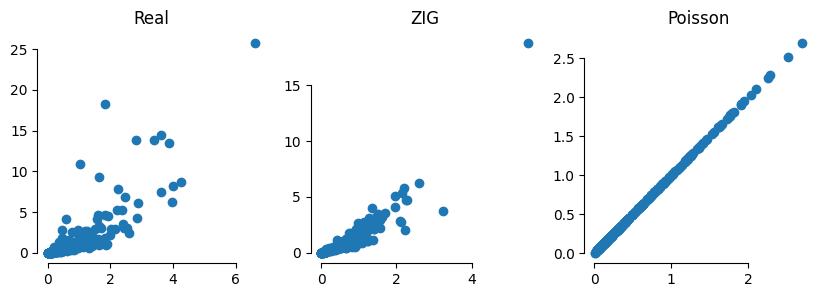

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(real_means[:, 0], real_variances[:, 0])
axes[0].set_title("Real")

axes[1].scatter(zig_means[:, 0], zig_variances[:, 0])
axes[1].set_title("ZIG")

axes[2].scatter(poisson_means[:, 0], poisson_variances[:, 0])
axes[2].set_title("Poisson")

sns.despine(trim=True)

In [140]:
from neuralpredictors.measures import corr

zig_mean_corr = corr(zig_means, real_means, axis=0).mean(0)
zig_var_corr = corr(zig_variances, real_variances, axis=0).mean(0)
poisson_mean_corr = corr(poisson_means, real_means, axis=0).mean(0)
poisson_var_corr = corr(poisson_variances, real_variances, axis=0).mean(0)



print(zig_mean_corr, zig_var_corr)
print(poisson_mean_corr, poisson_var_corr)

0.27001536 0.16237831
0.3396199 0.21391572
